some description

#Set Up

##Libraries

In [0]:
#Import spark library
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

#ipmort python libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

##Snowflake Class

In [0]:
%run ./Snowflake_Connection_rgb

#Pull Forecasts

##Function: read_fct_extract
read and transform the forecast extract table  

Parameters
- type of volume to pull as a string

Output
- clean forecast dataframe

In [0]:
def read_fct_extract(volume_type):
    
    #set up column names based on spc
    vol = 'forecast_volume'
    rename = 'fct_volume'
    if volume_type == 'spc':
        vol = 'forecast_volume_spc'
        rename = 'fct_volume_spc'
    
    #pull table
    df = spark.read.table('rgb_db.forecast_extract_full')
    #cast profit center to integer
    df = df.withColumn('profit_center', df.profit_center.cast('bigint'))
    
    #clean up dataframe
    df = (df.select('year', 'week', 'super_channel', 'retailer', 'profit_center', 'material', vol, 'forecast_date')
          .withColumns({'fct_year' : df.year, 'fct_week' : df.week})
          .drop('year', 'week')
          .withColumnRenamed(vol,rename)
     )
    
    return df

##Function: read_date_table
read and transform the date table from snowflake. Pull 2019-2023

Parameters
- none

Output
- dataframe of dates with swire weeks

In [0]:
def read_date_table():
    #initialize the class
    sfdt = SnowflakeDataTool()

    #build query to pull days from date table
    query = "select date, swire_year_number, swire_week_of_year_number \
        from db_swire_bi_p_edw.transformed.dim_mdm_date \
        where date > '2018-12-31' and date < '2023-12-31'\
        ;"

    #pull from snowflake
    date_table = sfdt.sql(query)

    #covnert to lowercase column names
    for col in date_table.columns:
        date_table = date_table.withColumnRenamed(col, col.lower())

    #rename columns and cast as int
    date_table = (date_table
                  .withColumn('year', date_table.swire_year_number.cast('int'))
                  .withColumn('week', date_table.swire_week_of_year_number.cast('int'))
                  .drop('swire_year_number','swire_week_of_year_number')
                 )
    
    return date_table

##Function: transform_fct_lags
join forecast and date table and build lag column

Parameters
- forecast dataframe
- date table dataframe

Output
- forecast dataframe with relevant lags

In [0]:
def transform_fct_lags(df_fct, df_date):

    #join swire dates onto forecast
    df = (df_fct.join(df_date, df_fct.forecast_date == df_date.date, 'inner') #inner join for speed
           .drop('forecast_date', 'date') #drop key columns
           .withColumn('lag', ((df_fct.fct_year-2000)*52+df_fct.fct_week) - ((df_date.year-2000)*52+df_date.week) ) #calculate lag as integer
           .drop('year', 'week')#remove swire year-week columns
    )
    
    return df

#Pull Actuals

##Function: read_act_demand
read and transform the actual demand table

Parameters
- none

Output
- dataframe of actual demand at a daily grain

In [0]:
def read_act_demand():
    #pull table
    df_act = spark.table('ltf_db.ltf_fp_daily_demand_sf_date')
    
    #convert to lowercase column names
    for col in df_act.columns:
        df_act = df_act.withColumnRenamed(col, col.lower())
    
    #clean up
    df_act = (df_act
              .withColumn('material', df_act.material_id.cast('int'))#convert to integer
              .withColumnRenamed('ordered_daily_sum', 'demand')#rename demand
              .withColumnRenamed('date', 'demand_date')#rename date for join
              .drop('material_id')
             )
    
    return df_act

##Function: read_customer_master
read and transform the customer table from snowflake

Parameters
- none

Output
- dataframe of customer master table

In [0]:
def read_customer_master():
    #initialize the class
    sfdt = SnowflakeDataTool()

    #build query
    query = "select c.customer_number, c.super_channel, c.key_account_plan_cp3, c.profit_center \
        from db_swire_bi_p_edw.transformed.dim_mdm_customer_master c \
        ;"

    #pull from snowflake
    cust = sfdt.sql(query)

    #covnert to lowercase column names
    for col in cust.columns:
        cust = cust.withColumnRenamed(col, col.lower())

    #drop any nulls
    cust = cust.dropna()

    #convert column types and drop unneeded columns
    cust = (cust
            .withColumn('retailer', cust.key_account_plan_cp3.cast('int'))
            .withColumn('profit_center', cust.profit_center.cast('bigint'))
            .drop('key_account_plan_cp3')
           )
    
    return cust

##Function: transform_act_demand
join the actual demand with customer details and aggregate to proper grain

Parameters
- dataframe of actual demand at daily grain
- dataframe of date dimension
- dataframe of customer master table

Output
- dataframe of actual demand aggregated at proper grain

In [0]:
def transform_act_demand(df_act,df_date,df_cust):
    #join date and customer details and aggregate
    df = (df_act.join(df_date, df_act.demand_date == df_date.date, 'inner') #inner join for speed
          .drop('demand_date', 'date') #drop date key columns
          .join(df_cust, df_act.customer_id == df_cust.customer_number, 'inner') #inner join will remove any customers not in dimension
          .drop('customer_id','customer_number') #drop customer key columns
          .groupby('material', 'year', 'week', 'super_channel', 'retailer', 'profit_center')#group over grain
          .agg(F.sum('demand').alias('demand'))#aggregate demand
    )

    return df

#Join Actuals with Forecast

##Function: min_max_year_week
extract minimum week from a dataframe

Parameters
- dataframe with a year and week column
- name of year column as string
- name of week column as string

Output
- year of minimum week as integer
- minimum week as integer
- year of maximum week as integer
- maximum week as integer

In [0]:
def min_max_year_week(df,year_col,week_col):
    #minimum year
    min_year = df.agg(F.min(year_col)).collect()[0][0]
    #minimum week in minimum year
    min_week = df.filter(col(year_col) == min_year).agg(F.min(week_col)).collect()[0][0]
    #maximum year
    max_year = df.agg(F.max(year_col)).collect()[0][0]
    #maximum week in maximum year
    max_week = df.filter(col(year_col) == max_year).agg(F.max(week_col)).collect()[0][0]
    
    return min_year, min_week, max_year, max_week

##Function: time_df_date
filter actual and forecast dataframes to have equivalent date ranges

Parameters
- dataframe of actual demand aggregated at proper grain
- forecast dataframe with relevant lags

Output
- dataframe of actual demand aggregated at proper grain
- forecast dataframe with relevant lags

In [0]:
def trim_df_date(df_tr_act, df_tr_fct):
    #EXTRACT MIN AND MAX
    
    #get minimum/max actuals week
    act_min_year, act_min_week, act_max_year, act_max_week = min_max_year_week(df_tr_act,'year','week')
    #get minimum.max forecast week
    fct_min_year, fct_min_week, fct_max_year, fct_max_week = min_max_year_week(df_tr_fct,'fct_year','fct_week')
    
    #TRIM THE OLD
    
    #convert to comparable numbers
    act = (act_min_year-2000)*52 + act_min_week
    fct = (fct_min_year-2000)*52 + fct_min_week

    #set actual year,week as most recent
    max_year = act_min_year
    max_week = act_min_week
    #if forecast is most recent, set forecast year,week as most recent
    if fct > act:
        max_year = fct_min_year
        max_week = fct_min_week
        
    #filter dataframe with dates that go further back
    if fct > act: #case where forecast ends more recently
        df_tr_act = (df_tr_act #filter actuals to match forecast
                     .filter(df_tr_act.year>= max_year)
                     .filter( (df_tr_act.year > max_year) | (df_tr_act.week >= max_week) )
                    )
    elif act > fct: #case where actuals end more recently
        df_tr_fct = (df_tr_fct #filter forecast to match actuals
                     .filter(df_tr_fct.fct_year>= max_year)
                     .filter( (df_tr_fct.fct_year > max_year) | (df_tr_fct.fct_week >= max_week) )
                    )
    #case where they are equal nothing is filtered
    
    #TRIM THE NEW
    
    #convert to comparable numbers
    act = (act_max_year-2000)*52 + act_max_week
    fct = (fct_max_year-2000)*52 + fct_max_week

    #set actual year,week as least recent
    min_year = act_max_year
    min_week = act_max_week
    #if forecast is less recent, set forecast year,week as least recent
    if fct < act:
        min_year = fct_max_year
        min_week = fct_max_week
        
    #filter dataframe with dates that go further back
    if fct < act: #case where forecast ends first
        df_tr_act = (df_tr_act #filter actuals to match forecast
                     .filter(df_tr_act.year<= min_year)
                     .filter( (df_tr_act.year < min_year) | (df_tr_act.week <= min_week) )
                    )
    elif act < fct: #case where actuals end first
        df_tr_fct = (df_tr_fct #filter forecast to match actuals
                     .filter(df_tr_fct.fct_year<= min_year)
                     .filter( (df_tr_fct.fct_year < min_year) | (df_tr_fct.fct_week <= min_week) )
                    )
    #case where they are equal nothing is filtered
    
    return df_tr_act, df_tr_fct, max_year, max_week, min_year, min_week
        

##Function: join_act_fct
join the actual demand with the forecast

Parameters
- dataframe of actual demand aggregated at proper grain
- dataframe of forecast with relevant lags

Output
- Full outer join of actuals and forecast

In [0]:
def join_act_fct(df_act,df_fct):
    #rename columns so we don't have ambiguity issues
    df_fct = (df_fct
              .withColumnRenamed('super_channel', 'fct_super_channel')
              .withColumnRenamed('retailer','fct_retailer')
              .withColumnRenamed('profit_center','fct_profit_center')
              .withColumnRenamed('material','fct_material')
             )
    
    #define join conditions
    cond = [df_act.year == df_fct.fct_year,
            df_act.week == df_fct.fct_week,
            df_act.super_channel == df_fct.fct_super_channel,
            df_act.retailer == df_fct.fct_retailer,
            df_act.profit_center == df_fct.fct_profit_center,
            df_act.material == df_fct.fct_material]
    
    #set up join
    df = (df_act
          .join(df_fct, cond, 'outer') #outer join to capture nulls on both sides
          .withColumn('year', F.coalesce(df_act.year, df_fct.fct_year)) #fill left side key columns
          .withColumn('week', F.coalesce(df_act.week, df_fct.fct_week))
          .withColumn('super_channel', F.coalesce(df_act.super_channel, df_fct.fct_super_channel))
          .withColumn('retailer', F.coalesce(df_act.retailer, df_fct.fct_retailer))
          .withColumn('profit_center', F.coalesce(df_act.profit_center, df_fct.fct_profit_center))
          .withColumn('material', F.coalesce(df_act.material, df_fct.fct_material))
          .drop('fct_year', 'fct_week', 'fct_super_channel', 'fct_retailer', 'fct_profit_center', 'fct_material')#drop right side keys
         )
    
    return df

#EDA of join

##Function: eda_row_count
evaluate missing rows in dataframe

Parameters
- dataframe of actual demand joined with forecast
- joined dataframe with only null forecast rows
- joined dataframe with only null demand rows

Output
- print rows statistics

In [0]:
def eda_row_count(df, df_fct_null, df_act_null):
    
    #counts
    nrow = df.count() #total rows
    act_row = df_fct_null.count() #rows with actuals missing forecast 
    fct_row = df_act_null.count() #rows with forecasts missing actuals
    full_row = nrow - act_row - fct_row #rows with both
    
    #percentages
    miss_fct_row_pct = str(act_row / nrow *100)[:4]+'%' #missing fct pct
    miss_act_row_pct = str(fct_row / nrow *100)[:4]+'%' #missing act pct
    full_row_pct = str(full_row / nrow *100)[:4]+'%' #full row pct
    
    print('Total Rows:           ', '{:10d}'.format(nrow), 'pct:', '100%', sep='\t')
    print('Rows Missing Forecast:', '{:10d}'.format(act_row), 'pct:', miss_fct_row_pct, sep='\t')
    print('Rows Missing Actuals: ', '{:10d}'.format(fct_row), 'pct:', miss_act_row_pct, sep='\t')
    print('Full Rows:            ', '{:10d}'.format(full_row), 'pct:', full_row_pct, sep='\t')
    

##Function: eda_grain_count
evaluate missing grains in dataframe

Parameters
- dataframe of actual demand joined with forecast
- joined dataframe with only null forecast rows
- joined dataframe with only null demand rows

Output
- print grain statistics

In [0]:
def eda_grain_count(df, df_fct_null, df_act_null):
    
    #counts
    grain = (df #total instances of grain
             .groupby('year', 'week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
             .agg(F.count('demand')) #arbitrary function to return df
             .count()
            )
    act_grain = (df_fct_null #grains of actuals missing forecasts
                 .groupby('year', 'week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
                 .agg(F.count('demand')) #arbitrary function to return df
                 .count()
                )
    fct_grain = (df_act_null #grains of forecasts missing actuals
                 .groupby('year', 'week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
                 .agg(F.count('demand')) #arbitrary function to return df
                 .count()
                )
    full_grain = grain - act_grain - fct_grain #grains with both
    
    #percentages
    miss_fct_grain_pct = str(act_grain / grain *100)[:4]+'%' #missing fct pct
    miss_act_grain_pct = str(fct_grain / grain *100)[:4]+'%' #missing act pct
    full_grain_pct = str(full_grain / grain *100)[:4]+'%' #full grain pct
    
    print('Total Grains:           ', '{:10d}'.format(grain), 'pct:', '100%', sep='\t')
    print('Grains Missing Forecast:', '{:10d}'.format(act_grain), 'pct:', miss_fct_grain_pct, sep='\t')
    print('Grains Missing Actuals: ', '{:10d}'.format(fct_grain), 'pct:', miss_act_grain_pct, sep='\t')
    print('Full Grains:            ', '{:10d}'.format(full_grain), 'pct:', full_grain_pct, sep='\t')


##Function: eda_demand_sum
evaluate missing demand in dataframe

Parameters
- dataframe of actual demand aggregated at proper grain
- joined dataframe with only null forecast rows

Output
- print demand statistics

In [0]:
def eda_demand_sum(df_tr_act, df_fct_null):
    
    #counts
    demand = df_tr_act.groupby().sum('demand').collect()[0][0] #total demand
    act_demand = df_fct_null.groupby().sum('demand').collect()[0][0] #demand of actuals missing forecasts
    
    #percentages
    miss_fct_demand_pct = str(act_demand / demand *100)[:4]+'%' #missing fct pct
    
    print('Total Demand:           ', '{:15.2f}'.format(demand), 'pct:', '100%', sep='\t')
    print('Demand Missing Forecast:', '{:15.2f}'.format(act_demand), 'pct:', miss_fct_demand_pct, sep='\t')
    

##Function: eda_forecast_average
evaluate missing forecast in dataframe

Parameters
- dataframe of forecast with relevant lags
- joined dataframe with only null demand rows

Output
- print forecast statistics

In [0]:
def eda_forecast_average(df_tr_fct, df_act_null):
    #counts
    forecast = (df_tr_fct
                .groupby('fct_year', 'fct_week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
                .agg(F.avg('fct_volume').alias('fct_volume')) #take average forecast over all lags
                .groupby()
                .sum('fct_volume')
                .collect()[0][0] #total forecast
               )
    fct_forecast = (df_act_null #take rows with no demand
                    .groupby('year', 'week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
                    .agg(F.avg('fct_volume').alias('fct_volume')) #take average forecast over all lags
                    .groupby()
                    .sum('fct_volume')
                    .collect()[0][0] #total forecast for forecasts missing demand
                   )
    
    #percentages
    miss_act_forecast_pct = str(fct_forecast / forecast *100)[:4]+'%' #missing act pct
    
    print('Total Forecast:         ', '{:15.2f}'.format(forecast), 'pct:', '100%', sep='\t')
    print('Forecast Missing Demand:', '{:15.2f}'.format(fct_forecast), 'pct:', miss_act_forecast_pct, sep='\t')

#Pull, Join, EDA Job

##Job: ingest_eda_job
combine all above steps
ingest and transform actuals and forecast; trim and join actuals and forecast; output EDA on joined table

Parameters
- type of volume to pull as a string

Output
- print EDA statistics
- Full outer join of actuals and forecast

In [0]:
def ingest_eda_job(volume_type):
    #pull data
    df_fct = read_fct_extract(volume_type)
    df_date = read_date_table()
    df_act = read_act_demand()
    df_cust = read_customer_master()
    
    #transform data
    df_tr_fct = transform_fct_lags(df_fct,df_date)
    df_tr_act = transform_act_demand(df_act,df_date,df_cust)
    
    #trim data
    df_tr_act, df_tr_fct, first_year, first_week, last_year, last_week = trim_df_date(df_tr_act, df_tr_fct)
    
    #join data
    df_join = join_act_fct(df_tr_act,df_tr_fct)
    
    #filter joined data for eda
    df_fct_null = df_join.filter(df_join.lag.isNull()) #rows with actuals, missing forecast 
    df_act_null = df_join.filter(df_join.demand.isNull()) #rows with forecasts, missing actuals
    
    print('Showing data for week',first_year,first_week,'to',last_year,last_week)
    print()
    print('### Row Stats ###')
    print()
    eda_row_count(df_join, df_fct_null, df_act_null)
    print()
    print('### Grain Stats ###')
    print()
    eda_grain_count(df_join, df_fct_null, df_act_null)
    print()
    print('### Demand Stats ###')
    print()
    eda_demand_sum(df_tr_act, df_fct_null)
    print()
    print('### Forecast Stats ###')
    print()
    eda_forecast_average(df_tr_fct, df_act_null)
    
    return df_join

In [0]:
#df = ingest_eda_job('std')

#note table is saved at rgb_db.act_demand_sales_forecast

this is the output of the above cell  
Showing data for week 2021 9 to 2023 7

### Row Stats ###

Total Rows:           	 465191162	pct:	100%  
Rows Missing Forecast:	   3738568	pct:	0.80%  
Rows Missing Actuals: 	 181200241	pct:	38.9%  
Full Rows:            	 280252353	pct:	60.2%  

### Grain Stats ###

Total Grains:           	  25773464	pct:	100%  
Grains Missing Forecast:	   3738568	pct:	14.5%  
Grains Missing Actuals: 	  11207433	pct:	43.4%  
Full Grains:            	  10827463	pct:	42.0%  

### Demand Stats ###

Total Demand:           	   388123992.14	pct:	100%  
Demand Missing Forecast:	    66766144.80	pct:	17.2%  

### Forecast Stats ###

Total Forecast:         	   411630519.67	pct:	100%  
Forecast Missing Demand:	    81867443.74	pct:	19.8%

#Accuracy

##Function: clean_act_fct_df
deal with nulls in joined dataframe

Parameters
- join of actuals and forecast
- option as integer
  - 1: keep only full rows
  - 2: delete rows missing forecast, fill null demand with 0
  - Other: do not change df

Output
- filtered join of actuals and forecast

In [0]:
def clean_act_fct_df(df,option):
    if option == 1:
        #option 1: only full rows
        df = df.filter( (df.demand.isNotNull()) & (df.lag.isNotNull()) )
    elif option == 2:
        #option 2: remove missing forecast, fill demand with 0
        df = df.filter(df.lag.isNotNull()).fillna({'demand': 0})
        
    return df
    

##Function: accuracy
calculate accuracy for one lag

Parameters
- filtered join of actuals and forecast (no nulls)

Output
- dataframe of demand, error, accuracy by lag

In [0]:
def accuracy(df):
    #group by lag and sum error and demand
    df = (df
          .withColumn('error', df.fct_volume - df.demand) 
          .withColumn('abs_error', F.abs(df.fct_volume - df.demand))
          .withColumn('over_forecast', F.when(df.demand > df.fct_volume, 0).otherwise(df.fct_volume - df.demand)) #forecast > demand
          .withColumn('under_forecast', F.when(df.fct_volume > df.demand, 0).otherwise(df.fct_volume - df.demand)) #demand > forecast, report as negative           
          .groupby('lag')
          .agg(F.sum('demand').alias('tot_demand'),
               F.sum('error').alias('tot_error'),
               F.sum('abs_error').alias('tot_abs_error'),
               F.sum('over_forecast').alias('tot_over_forecast'),
               F.sum('under_forecast').alias('tot_under_forecast')
              )
         )
    #add column for accuracy by lag
    df = (df
          .withColumn('bias', df.tot_error / df.tot_demand)
          .withColumn('accuracy', df.tot_abs_error / df.tot_demand)
         )
    
    return df
    

##Function: convert_acc_to_pandas
convert accuracy dataframe to pandas

Parameters
- accuracy dataframe

Output
- pandas accuracy dataframe

In [0]:
def convert_acc_to_pandas(df_acc):
    #convert
    pdf_acc = df_acc.select('lag','accuracy').toPandas()
    
    #add column
    pdf_acc['neg_lag'] = pdf_acc['lag']*(-1)
    
    return pdf_acc

##Job: clean_convert_job
combine all above steps
deal with missing values; calculate accuracy; convert to pandas

Parameters
- Full outer join of actuals and forecast
- option as integer

Output
- dataframe of demand, error, accuracy by lag
- pandas accuracy dataframe

In [0]:
def clean_convert_job(df,option):
    #clean data with given option
    df = clean_act_fct_df(df,option)
    #create accuracy dataframe
    df_acc = accuracy(df)
    #convert to pandas
    pdf_acc = convert_acc_to_pandas(df_acc)
    pdf_acc = pdf_acc.sort_values(by='neg_lag', ascending=True)
    
    return df_acc, pdf_acc

##Function: accuracy_plot
plot accuracy against lags

Parameters
- accuracy pandas dataframe
- title as string

Output
- accuracy plot

In [0]:
def accuracy_plot(pdf_acc, title):    
    #set figure size and save variable
    plt.figure(figsize=(15,5))

    #set the style of plot
    plt.style.use('seaborn-bright')

    # plot
    plt.plot('neg_lag', 'accuracy', data=pdf, marker='o')

    # Add titles
    plt.suptitle('Accuracy by Lag', x=0.18, fontsize=14, fontweight=0.5)
    plt.title(title, loc='left', fontsize=10)
    plt.xlabel("Lags", fontsize = 10)
    plt.ylabel("wMAPE", fontsize = 10)
    
    #plt.ylim(0,1)

    # show the graph
    plt.show()

#Results

In [0]:
df = spark.read.table('rgb_db.act_demand_sales_forecast')

In [0]:
acc, pdf = clean_convert_job(df,1)

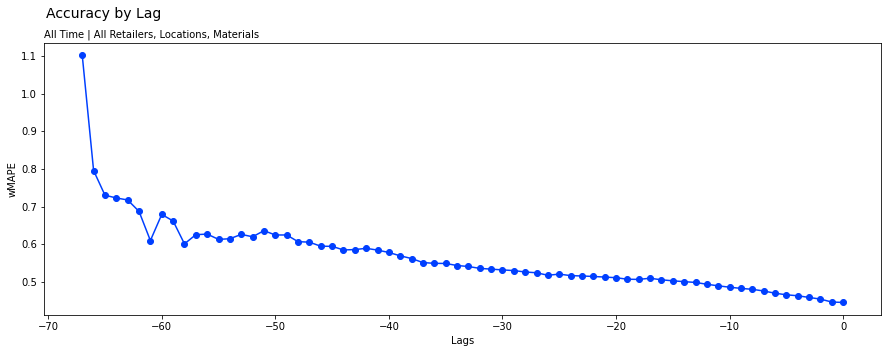

In [0]:
accuracy_plot(pdf, 'All Time | All Retailers, Locations, Materials')

In [0]:
acc.display()

lag,tot_demand,tot_error,tot_abs_error,tot_over_forecast,tot_under_forecast,bias,accuracy
31,139011451.707,9354998.99293552,7.422890299372452E7,4.179195099333005E7,-3.2436952000394523E7,0.06729660670441329,0.5339768924230772
65,8058105.451,1226560.3334298886,5883967.684866686,3555264.009148288,-2328703.6757183983,0.1522144803004128,0.7301924404745155
53,33487932.133,2027252.2018732093,2.0968431486594833E7,1.1497841844234025E7,-9470589.642360812,0.06053679856438478,0.6261488886001391
34,121417279.698,8358433.394747824,6.599598625946476E7,3.717720982710632E7,-2.8818776432358474E7,0.06884055890181096,0.5435469022499592
28,157326538.219,8292985.996852044,8.281467215431128E7,4.5553829075581744E7,-3.726084307872972E7,0.052711933350418794,0.5263871759450557
27,163720205.300,8330308.301733367,8.584172871298565E7,4.708601850735956E7,-3.875571020562623E7,0.050881369751943295,0.5243196986938157
26,168644489.514,6128062.475200983,8.730558598538682E7,4.671682423029401E7,-4.058876175509309E7,0.036337164012063744,0.5176901198312748
44,61003636.714,7406942.30097604,3.568100909145921E7,2.1543975696217656E7,-1.4137033395241572E7,0.12141804488971043,0.58489970456582
12,260698408.420,4335539.151536119,1.2873135060499114E8,6.6533444878263734E7,-6.219790572672773E7,0.01663047802175807,0.4937941561867827
22,193415758.161,4952222.986079354,9.950946081954187E7,5.223084190281062E7,-4.7278618916731335E7,0.025604030577266124,0.5144847646628141


In [0]:
pdf

,lag,accuracy,neg_lag
64,67,1.101300,-67
62,66,0.795556,-66
1,65,0.730192,-65
24,64,0.722777,-64
42,63,0.717511,-63
...,...,...,...
33,4,0.463258,-4
16,3,0.458866,-3
60,2,0.454342,-2
11,1,0.446658,-1


#Appendix

##Function: pvt_fct
pivot forecast table into final format

In [0]:
# def pvt_fct(df, rename):
#     #get all unique lag values
#     fct_lags = [row[0] for row in df.select('lag').distinct().collect()]
#     fct_lags.sort() #sort so it shows in df in order
    
#     #pivot the dataframe
#     pvt = (df.groupby('fct_year', 'fct_week', 'super_channel', 'retailer', 'profit_center', 'material') #group by grain
#            .pivot('lag', fct_lags) #give list for faster execution
#            .agg(F.avg(rename)) #use average where we have two rows
#           )
    
#     return pvt

##Job: job_lag_fct
combine all above steps

Parameters
- volume type as string

Output
- forecast dataframe with relevant lags

In [0]:
# def job_lag_fct(volume_type, df_date):
#     #read forecast data
#     df_fct = read_fct_extract(volume_type)
#     #read snowflake date table
#     df_date = read_date_table()
#     #build lags
#     df_lag = fct_lags(df_fct,df_date)
    
#     return df_lag
    

In [0]:
# #this was a piece of the fct_lags function

# #convert lag to string column
# df = df.withColumn('lead_lag',F.concat(lit('0'),df.int_lag))
# df = df.withColumn('str_lag', F.substring('lead_lag',-2,2))
# df = df.withColumn('lag', F.concat(lit('forecast_'),df.str_lag)).drop('int_lag', 'lead_lag', 'str_lag')

##Job: job_act_fct
combine all above steps

In [0]:
# def job_act_fct(min_year, min_week):
#     #pull actual demand
#     df_act = read_act_demand(min_year,min_week)
#     #pull customer details
#     df_cust = read_customer_master()
#     #join actuals with customer details and aggregate
#     df = join_act_cust(df_act,df_cust)
    
#     return df


In [0]:
# #old accuracy
# df_acc = (df
#               .filter(df.lag == lag) #filter for lag
#               .agg(F.sum('error').alias('tot_error'), F.sum('demand').alias('tot_demand')) #sum error and demand
#              )
    
#     #calculate accuracy
#     accuracy = df_acc.withColumn('accuracy', df_acc.tot_error / df_acc.tot_demand).collect()[0][2]

##Function: accuracy_df
calculate accuracy for all lags and save as pandas df

In [0]:
# def accuracy_df(df,lags):
#     #initialize list
#     acc_list = []
#     #iterate through lags
#     for lag in lags:
#         #calculate accuracy for each lag
#         acc = accuracy(df, lag)
#         #add to list
#         acc_list.append(acc)
        
#     # create a dictionary from the lists
#     data = {"lag": lags, "acc": acc_list}

#     # create a Pandas DataFrame from the dictionary
#     pdf = pd.DataFrame(data)
    
#     return pdf

In [0]:
# #fsop

# df.filter( (df.super_channel == 'F') | (df.super_channel == 'O') ).display()

# df_fsop = df.filter( (df.super_channel == 'F') | (df.super_channel == 'O') )

# df_fsop.write.mode('overwrite').saveAsTable('rgb_db.fsop_act_demand_sales_forecast')

# #read data
# dftest = spark.read.table('rgb_db.fsop_act_demand_sales_forecast') #view data
# dftest.display() #select columns
# dftest.select('material', 'demand') #filter rows
# dftest.filter(dftest.lag == 4)
